In [0]:
import os
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt
from tensorflow.python.estimator import estimator
from google.colab import drive, auth

In [0]:
R, C = 4, 3
EXAMPLES = R * C
CHANNELS = 4

ADD_NOISE_TO_EXAMPLE = True
ALPHA = 0.2
BATCH_SIZE = 1024
EPOCHS = 60000
EVAL_EPOCHS = 3000
G_LR = 0.0002
D_LR = 0.0001
LR_STD = 1
LR_REC = 3
LR_FEAT = 10
KERNEL_SIZE = 4
NUM_CLASSES = 99

MODEL_NAME = 'FUNIT_new'
# two layers in mlp
RUN_NAME = 'FUNIT_new_hope_46'

data_train_file = 'gs://tputestingmnist/datasets/dataset_train_funit_6.tfrecords'
data_test_file = 'gs://tputestingmnist/datasets/dataset_test_funit_6.tfrecords'
MODEL_DIR = 'gs://tputestingmnist/{}/{}/'.format(MODEL_NAME, RUN_NAME)
GOOGLE_DRIVE_DIR = '/content/gdrive/My Drive/Programowanie/PixelGen/{}'.format(RUN_NAME)
TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])

In [0]:
#################################### SETUP #####################################

def setup():
    drive.mount('/content/gdrive')
    auth.authenticate_user()


def upload_credentials():
    # Upload credentials to TPU.
    with tf.Session(TF_MASTER) as sess:    
        with open('/content/adc.json', 'r') as f:
            auth_info = json.load(f)
        tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)

In [0]:
################################# DATA INPUT ###################################

def augment(image):
    # image = tf.image.random_flip_left_right(image)

    image_rgb = image[:,:,:3]
    image_rgb = tf.image.random_hue(image_rgb, 0.1)
    image_rgb = tf.image.random_saturation(image_rgb, 0.8, 1.2)
    image_rgb = tf.image.random_brightness(image_rgb, 0.05)
    image_rgb = tf.image.random_contrast(image_rgb, 0.8, 1.2)
    
    return tf.concat([image_rgb, image[:,:,3:4]], axis=2)


def get_parser(add_noise = ADD_NOISE_TO_EXAMPLE, is_predict=False, augment_fun = lambda x: x):
    def parser(serialized_example):
            """Parses a single example into image and label tensors."""
            features = tf.parse_single_example(
                serialized_example,
                features={
                    'height': tf.FixedLenFeature([], tf.int64), 
                    'width':tf.FixedLenFeature([], tf.int64), 
                    'depth': tf.FixedLenFeature([], tf.int64), 
                    'train_examples': tf.FixedLenFeature([], tf.int64), 
                    'test_examples': tf.FixedLenFeature([], tf.int64), 
                    'image_content': tf.FixedLenFeature([], tf.string),
                    'image_style': tf.FixedLenFeature([], tf.string),
                    'label': tf.FixedLenFeature([], tf.int64), 
                    'label_content': tf.FixedLenFeature([], tf.int64) 
                })

            content_image = tf.decode_raw(features['image_content'], tf.uint8)
            content_image.set_shape([48 * 48 * 4])
            content_image = tf.reshape(content_image, [48, 48, 4])[:,:,:CHANNELS]
            content_image = augment_fun(content_image)
            # Normalize the values of the image from [0, 255] to [-1.0, 1.0]
            content_image = tf.cast(content_image, dtype=tf.float32) / 127.5 - 1
            if add_noise:
                content_image += tf.random_normal(shape=tf.shape(content_image), mean=0.0, stddev=0.1, dtype=tf.float32)

            style_examples = 2 if is_predict else 1
            style_images = tf.decode_raw(features['image_style'], tf.uint8)
            style_images.set_shape([48 * 48 * 4 * style_examples])
            style_images = tf.reshape(style_images, [48, 48, 4, style_examples])[:,:,:CHANNELS,:]
            style_images_processed = []
            for style_image in tf.unstack(style_images, axis=3):
                style_image = augment_fun(style_image)
                # Normalize the values of the image from [0, 255] to [-1.0, 1.0]
                style_image = tf.cast(style_image, dtype=tf.float32) / 127.5 - 1
                if add_noise:
                    style_image += tf.random_normal(shape=tf.shape(style_image), mean=0.0, stddev=0.1, dtype=tf.float32)        
                style_images_processed.append(style_image)
            
            style_label, content_label = features['label'], features['label_content']
            return {'style_images': style_images_processed, 'content_images': content_image, 
                    'style_labels': style_label, 'content_labels': content_label}, style_label
    return parser


def make_input_fn(is_training=True, one_batch=False, is_predict=False):
    def input_fn(params):
        batch_size = params['batch_size']
        dataset = tf.data.TFRecordDataset(data_train_file, buffer_size=8*1024*1024)
        if is_training:
            dataset = dataset.map(get_parser(True, is_predict, augment)).cache().shuffle(batch_size)
        else:
            dataset = dataset.map(get_parser(False, is_predict)).cache().shuffle(batch_size)

        if is_training:
            dataset = dataset.repeat()
        if one_batch:
            dataset = dataset.take(params['batch_size'])
            
        dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(8)

        return dataset
    return input_fn

def predict_fn(params):
    batch_size = params['batch_size']
    dataset = tf.data.TFRecordDataset(data_test_file, buffer_size=8*1024*1024)
    dataset = dataset.map(get_parser(False, is_predict=True)).cache().shuffle(batch_size)
    dataset = dataset.take(params['batch_size'])
        
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(8)
    return dataset


In [91]:
with tf.Session() as sess:
    dataset = tf.data.TFRecordDataset(data_train_file, buffer_size=8*1024*1024)
    for row in dataset:
        print(row)

RuntimeError: ignored

In [0]:
############################### DATA SAVEING ###################################
 
def images_to_zero_one(images):
        return np.clip(np.array(images) * 0.5 + 0.5, 0., 1.)


def save_imgs(epoch, images):
    if not os.path.exists(GOOGLE_DRIVE_DIR):
        os.mkdir(GOOGLE_DRIVE_DIR)

    # Rescale images to 0 - 1
    images = images_to_zero_one(images)
    rows = []
    for r in range(R):
        rows.append(np.concatenate([np.pad(images[r*C + c], pad_width=((5, 5), (5,5), (0,0))) for c in range(C)], axis=1))
    joined_image = np.concatenate(rows, axis=0)
    plt.imsave(os.path.join(GOOGLE_DRIVE_DIR, '{}.png'.format(epoch)), joined_image)

In [0]:
################################## MODEL #######################################

def _relu(x):
    return tf.nn.relu(x)


def _leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=ALPHA)


def _instance_norm(x):
    return tf.contrib.layers.instance_norm(x, scale=False, center=False)


def _make_adain_norm(beta, gamma, index):
    def _adain_norm(x):
        mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
        outputs = tf.nn.batch_normalization(x, mean, var, beta, gamma, variance_epsilon=1e-5, name='in_bn_{}'.format(index))
        return outputs
    return _adain_norm


def _dense(x, neurons, name, activation=None):
    return tf.layers.dense(x, neurons, name=name, activation=activation,
                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))


def _conv2d(x, filters, kernel_size, stride, name, activation=None):
    return tf.layers.conv2d(x, filters, [kernel_size, kernel_size], 
                            strides=[stride, stride], activation=activation,
                            padding='same', name=name,
                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))

def _pooling(x, kernel, stride, index):
    return tf.layers.average_pooling2d(x, pool_size=kernel, strides=stride, name='pool_{}'.format(index))

def _deconv2d(x, filters, stride, name, activation=None):
    return tf.layers.conv2d_transpose(x, filters, [KERNEL_SIZE, KERNEL_SIZE],
                                      strides=[stride, stride], activation=activation,
                                      padding='same', name=name,
                                      kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))


def convolution_block(x, filters, kernel_size, resize_factor, index, activation=_relu, activation_first=False, normalization=None):
    if activation and activation_first:
        x = activation(x)
    x = _conv2d(x, kernel_size=kernel_size, filters=filters, stride=resize_factor, activation=None, name='conv_{}'.format(index))
    if normalization:
        x = normalization(x)
    if activation and not activation_first:
        x = activation(x)
    return x


def deconvolution_block(x, filters, resize_factor, index, activation=_relu, normalization=None):
    x = _deconv2d(x, filters=filters, stride=resize_factor, activation=None, name='deconv_{}'.format(index))
    if normalization:
        x = normalization(x)
    if activation:
        x = activation(x)
    return x


def fully_connected_block(x, neurons, index, activation=_relu, normalization=None):
    x = _dense(x, neurons=neurons, activation=None, name='fc_{}'.format(index))
    if normalization:
        x = normalization(x)
    if activation:
        x = activation(x)
    return x


def residual_block(x, filters_in, filters_out, index, kernel_size=3, activation=_relu, activation_first=False, normalization=None):
    forwarded_x = convolution_block(x, filters_in, kernel_size, resize_factor=1, 
                                    index='res_con1_{}'.format(index), normalization=normalization,
                                    activation_first=activation_first, activation=activation)
    
    forwarded_x = convolution_block(forwarded_x, filters_out, kernel_size, resize_factor=1, 
                                    index='res_con2_{}'.format(index), normalization=normalization,
                                    activation_first=activation_first, activation=None)
    
    if filters_in != filters_out:
        x = convolution_block(x, filters_out, kernel_size=1, resize_factor=1, index='res_con3_{}'.format(index), activation=None)
    x = tf.add(forwarded_x, x)
    return x


def adain_residual_block(x, beta, gamma, filters_in, filters_out, index, activation=_relu, activation_first=False):
    with tf.variable_scope('adain_{}'.format(index)):
        normalization = _make_adain_norm(beta, gamma, index)
        return residual_block(x, filters_in, filters_out, index, 3, activation, activation_first, normalization)


def content_encoder(x):
    x = convolution_block(x, 64, kernel_size=7, resize_factor=1, normalization=_instance_norm, index='con1')
    x = convolution_block(x, 128, kernel_size=KERNEL_SIZE, resize_factor=2, normalization=_instance_norm, index='con2')
    x = convolution_block(x, 256, kernel_size=KERNEL_SIZE, resize_factor=2, normalization=_instance_norm, index='con3')
    x = convolution_block(x, 512, kernel_size=KERNEL_SIZE, resize_factor=2, normalization=_instance_norm, index='con4')
    
    x = residual_block(x, 512, 512, index='res1', normalization=_instance_norm)
    x = residual_block(x, 512, 512, index='res2', normalization=_instance_norm)
    return x


def class_encoder(x):
    x = convolution_block(x, 64, kernel_size=7, resize_factor=1, index='cls1')
    x = convolution_block(x, 128, kernel_size=KERNEL_SIZE, resize_factor=2, index='cls2')
    x = convolution_block(x, 256, kernel_size=KERNEL_SIZE, resize_factor=2, index='cls3')
    x = convolution_block(x, 512, kernel_size=KERNEL_SIZE, resize_factor=2, index='cls4')
    x = convolution_block(x, 1024, kernel_size=KERNEL_SIZE, resize_factor=2, index='cls5')
    x = _pooling(x, 3, 3, index='cls6')
    return x


def mlp(x, feature_number):
    x = fully_connected_block(x, 256, 'mlp1')
    # x = fully_connected_block(x, 256, 'mlp2')
    x = fully_connected_block(x, feature_number, 'mlp3', activation=None)
    
    return x


def split_into_four_variable_sets(class_vars, num_features):
    b1 = class_vars[:, :, :, :num_features]
    g1 = class_vars[:, :, :, num_features:2*num_features]
    b2 = class_vars[:, :, :, 2*num_features:3*num_features]
    g2 = class_vars[:, :, :, 3*num_features:]
    return b1, g1, b2, g2
    

def decoder(content_latent, class_latent):
    # class code
    encoder_features_num = content_latent.shape[3]
    class_vars = mlp(class_latent, 4*encoder_features_num)
    b1, g1, b2, g2 = split_into_four_variable_sets(class_vars, encoder_features_num)

    # ADAIN
    x = adain_residual_block(content_latent, b1, g1, 512, 512, index='res3')
    x = adain_residual_block(x, b2, g2, 512, 512, index='res4')

    # Scale up
    # x = deconvolution_block(x, 512, resize_factor=2, normalization=_instance_norm, index='dec0')
    x = deconvolution_block(x, 256, resize_factor=2, normalization=_instance_norm, index='dec1')
    x = deconvolution_block(x, 128, resize_factor=2, normalization=_instance_norm, index='dec2')

    x = deconvolution_block(x, CHANNELS, resize_factor=2, normalization=None, index='dec4', activation=tf.tanh)
    
    return x


class Funit:

    @staticmethod
    def discriminator(x, label, scope='Discriminator'):
        with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
            x = tf.squeeze(x)
            x = convolution_block(x, 64, kernel_size=7, resize_factor=1, index='disc_10')
            
            x = convolution_block(x, 64, kernel_size=KERNEL_SIZE, resize_factor=2, activation=_leaky_relu, index='disc_11')
            x = convolution_block(x, 128, kernel_size=KERNEL_SIZE, resize_factor=2, activation=_leaky_relu, index='disc_12')
            x = convolution_block(x, 256, kernel_size=KERNEL_SIZE, resize_factor=2, activation=_leaky_relu, index='disc_13')
            x = convolution_block(x, 512, kernel_size=KERNEL_SIZE, resize_factor=2, activation=_leaky_relu, index='disc_14')
            
            output = tf.layers.flatten(x)
            output = _dense(output, NUM_CLASSES, 'disc_out')
            
            return output, x
          
    @staticmethod
    def generator(image_content, image_style, scope='Generator', getter=None):
        with tf.variable_scope(scope, reuse=tf.AUTO_REUSE, custom_getter=getter):
            content_latent = content_encoder(image_content)
            class_latents = []
            for style_image in tf.unstack(image_style, axis=1):
                class_latents.append(class_encoder(style_image))
            class_latent = tf.reduce_mean(class_latents, axis=0)
            x = decoder(content_latent, class_latent)
            return x

In [0]:
# It's not exactly the norm, but taking mean instead of sum makes the losses more comparable
def l1_norm(x, axis=[1,2,3]):
    return tf.reduce_mean(tf.math.abs(x), axis=axis)

def hinge_loss_d(pred, y):
    return tf.nn.relu(1 - pred * y)

def hinge_loss_g(pred):
    return -pred

In [0]:
################################ MODEL FUN #####################################
def make_model_fn(model):

    def model_fn(features, labels, mode, params):
        with tf.GradientTape(persistent=True) as t:
            with tf.variable_scope('inputs'):
                content_images = features['content_images']
                style_images = features['style_images']
                t.watch(style_images)

            ema = tf.train.ExponentialMovingAverage(decay=0.999)
            def ema_getter(getter, name, *args, **kwargs):
                var = getter(name, *args, **kwargs)
                ema_var = ema.average(var)
                return ema_var if ema_var else var

            # PREDICT #
            if mode == tf.estimator.ModeKeys.PREDICT:
                generated_images = model.generator(content_images, style_images, getter=ema_getter)

                predictions = {
                    'generated_images': generated_images,
                    'content_images': content_images,
                }
                return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, predictions=predictions)

            generated_images = model.generator(content_images, style_images)

            style_labels = features['style_labels']
            content_labels = features['content_labels']
            
            # Labels
            d_on_data_labels = tf.ones_like(style_labels)
            d_on_g_labels = tf.zeros_like(style_labels)
            d_on_cr_labels = tf.zeros_like(content_labels)
            
            # Discriminator loss
            res = []
            feats = []
            for style_image in tf.unstack(style_images, axis=1):
                d_on_data_results, d_on_data_features = model.discriminator(style_image, style_labels)
                res.append(d_on_data_results)
                feats.append(d_on_data_features)
            d_on_data_results, d_on_data_features = tf.reduce_mean(res, axis=0), tf.reduce_mean(feats, axis=0)
            d_on_data_results = tf.gather_nd(d_on_data_results, tf.expand_dims(style_labels, axis=1), batch_dims=1)
            d_on_data_logits = tf.squeeze(d_on_data_results)
        
            d_on_g_results, d_on_g_features = model.discriminator(generated_images, style_labels)
            d_on_g_results = tf.gather_nd(d_on_g_results, tf.expand_dims(style_labels, axis=1), batch_dims=1)
            d_on_g_logits = tf.squeeze(d_on_g_results)

            # Content reconstruction
            generated_images_cr = model.generator(content_images, tf.expand_dims(content_images, axis=1))

            d_on_cr_results, d_on_cr_features = model.discriminator(generated_images_cr, content_labels)
            d_on_cr_results = tf.gather_nd(d_on_cr_results, tf.expand_dims(content_labels, axis=1), batch_dims=1)
            d_on_cr_logits = tf.squeeze(d_on_cr_results)
            
            # Variables
            d_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Discriminator')
            g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Generator')
            
            with tf.variable_scope('losses'):
                d_loss_real = hinge_loss_d(d_on_data_logits, 1)
                d_loss_fake = hinge_loss_d(d_on_g_logits, -1)
                d_loss_reg = 10 * tf.reduce_sum(t.gradient(d_loss_real, style_images) ** 2) / params['batch_size']
                
                d_loss = d_loss_real + d_loss_fake
                d_loss_reduced = tf.reduce_mean(d_loss) + d_loss_reg

                # Generator loss
                g_loss_gan = LR_STD * 0.5 * (hinge_loss_g(d_on_g_logits) + hinge_loss_g(d_on_cr_logits))
                g_loss_rec = LR_REC * l1_norm(generated_images_cr - content_images)
                g_loss_feat = LR_FEAT * l1_norm(tf.reduce_mean(d_on_g_features, axis=0) - tf.reduce_mean(d_on_data_features, axis=0), axis=[0,1,2])
                
                g_loss_reduced = tf.reduce_mean(g_loss_gan + g_loss_rec) + g_loss_feat
                
            # TRAIN #
            if mode == tf.estimator.ModeKeys.TRAIN:
                
                with tf.variable_scope('optimizer'):
                    d_optimizer = tf.train.AdamOptimizer(learning_rate=D_LR, beta1=0.5)
                    d_optimizer = tf.contrib.tpu.CrossShardOptimizer(d_optimizer)
                
                    g_optimizer = tf.train.AdamOptimizer(learning_rate=G_LR, beta1=0.5)
                    g_optimizer = tf.contrib.tpu.CrossShardOptimizer(g_optimizer)
            
                    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                        d_step = d_optimizer.minimize(d_loss_reduced, var_list=d_vars)
                        g_step = g_optimizer.minimize(g_loss_reduced, var_list=g_vars)
                        increment_step = tf.assign_add(tf.train.get_or_create_global_step(), 1)

                        ema_op = ema.apply(g_vars)
                        joint_op = tf.group([d_step, g_step, increment_step, ema_op])

                        a = tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=d_loss_reduced+g_loss_reduced, train_op=joint_op)
                        return a

            # EVAL #
            elif mode == tf.estimator.ModeKeys.EVAL:
                d_on_g_gradients = tf.reduce_mean(t.gradient(d_loss_fake, generated_images), axis=[1, 2, 3])
                def _eval_metric_fn(d_loss, g_loss_1, g_loss_2, g_loss_3, d_real_labels, d_gen_labels, d_real_logits, d_gen_logits, gradients):
                    real_pred = tf.math.round(tf.sigmoid(d_real_logits))
                    gen_pred = tf.math.round(tf.sigmoid(d_gen_logits))
                    joint_acc = tf.metrics.accuracy(labels=tf.concat([d_real_labels, d_gen_labels], axis=0), 
                                                    predictions=tf.concat([real_pred, gen_pred], axis=0))

                    return {
                        'discriminator_loss': tf.metrics.mean(d_loss),
                        'generator_loss': tf.metrics.mean(g_loss_1),
                        'generator_loss_recon': tf.metrics.mean(g_loss_2),
                        'generator_loss_match': tf.metrics.mean(g_loss_3),
                        'discriminator_joint_accuracy': joint_acc,
                        'gradients': tf.metrics.mean(tf.math.abs(gradients))
                    }

                return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=d_loss_reduced + g_loss_reduced,
                                                    eval_metrics=(_eval_metric_fn, [d_loss, g_loss_gan, g_loss_rec, 
                                                                                    tf.tile(tf.reshape(g_loss_feat, [-1]), [params['batch_size']]),
                                                                                    d_on_data_labels, d_on_g_labels,
                                                                                    d_on_data_logits, d_on_g_logits, d_on_g_gradients]))
    return model_fn

In [0]:
################################ ESTIMATORS ####################################

def make_estimators(model, only_cpu=False):
    model_fn = make_model_fn(model)
    
    config = tf.contrib.tpu.RunConfig(
        master=TF_MASTER,
        save_checkpoints_steps=EVAL_EPOCHS,
        save_checkpoints_secs=None,
        save_summary_steps=EVAL_EPOCHS,
        model_dir=MODEL_DIR,
        keep_checkpoint_max=3,
        tpu_config=tf.contrib.tpu.TPUConfig(iterations_per_loop=EVAL_EPOCHS))

    if not only_cpu:
        # TPU-based estimator used for TRAIN and EVAL
        est = tf.contrib.tpu.TPUEstimator(
            model_fn=model_fn,
            use_tpu=True,
            config=config,
            train_batch_size=BATCH_SIZE,
            eval_batch_size=BATCH_SIZE)
    else:
        est = None

    # CPU-based estimator used for PREDICT (generating images)
    cpu_est = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        use_tpu=False,
        config=config,
        predict_batch_size=EXAMPLES)
    
    return est, cpu_est

In [0]:
################################# TRAINING #####################################

def train(est, cpu_est):
    current_step = estimator._load_global_step_from_checkpoint_dir(MODEL_DIR)
    print('Starting training')

    while current_step < EPOCHS:
        next_checkpoint = int(min(current_step + EVAL_EPOCHS, EPOCHS))
        est.train(input_fn=make_input_fn(), max_steps=next_checkpoint)
        current_step = next_checkpoint
        print('Finished training step %d' % current_step)

        # Evaluation
        metrics = est.evaluate(input_fn=make_input_fn(False), steps=1)
        print('Finished evaluating')
        print(metrics)

        # Render some generated images
        generated_iter = cpu_est.predict(input_fn=predict_fn)
        images = []
        for p in generated_iter:            
            style_images = []
            for style_image in p['style_images']:
                style_images.append(style_image)
            images.append(np.concatenate([p['content_images'], *style_images, p['generated_images']], axis=1))
        save_imgs(str(current_step), images)

        generated_iter = cpu_est.predict(input_fn=make_input_fn(False, one_batch=True, is_predict=False))
        images = []
        for p in generated_iter:
            style_images = []
            for style_image in p['style_images']:
                style_images.append(style_image)
            images.append(np.concatenate([p['content_images'], *style_images, p['generated_images']], axis=1))
        save_imgs(str(current_step) + '_train', images)
        
        print('Finished generating images')

In [0]:
def do_experiment():
    setup()
    upload_credentials()
    model = Funit()
    est, cpu_est = make_estimators(model)
    train(est, cpu_est)

In [0]:
def split_into_frames(image):
    images = []
    for r in range(R):
        for c in range(C):
            images.append(image[48*r:48*(r+1), 48*c:48*(c+1), :CHANNELS])
    return np.array(images)

In [0]:
def back_into_shape(images):
    print(len(images))
    image = np.zeros((48*4, 48*3, CHANNELS))
    print(image.shape)
    for r in range(R):
        for c in range(C):
            image[48*r:48*(r+1), 48*c:48*(c+1), :CHANNELS] = images[r * C + c]
    return image

In [0]:
import random

def get_k_frames(image, k):
    images = split_into_frames(image)
    return np.array(random.sample(list(images), k))

In [56]:
setup()
upload_credentials()
model = Funit()
_, cpu_est = make_estimators(model)

def try_on_images(estimator, content_images, style_images):
    assert content_images.shape[0] == style_images.shape[0]

    def image_predict_input_fn(params):
        content_images_tensor = tf.constant(content_images * 2 - 1, dtype=tf.float32)
        style_images_tensor = tf.constant(style_images * 2 - 1, dtype=tf.float32)
        content_dataset = tf.data.Dataset.from_tensors(content_images_tensor)
        style_dataset = tf.data.Dataset.from_tensors(style_images_tensor)

        return {'style_images': style_dataset.make_one_shot_iterator().get_next(),
                'content_images': content_dataset.make_one_shot_iterator().get_next()}, None

    generated_iter = cpu_est.predict(input_fn=image_predict_input_fn)
    images = [p['generated_images'] for p in generated_iter]
    return images_to_zero_one(images)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
INFO:tensorflow:Using config: {'_model_dir': 'gs://tputestingmnist/FUNIT_new/FUNIT_new_hope_46/', '_tf_random_seed': None, '_save_summary_steps': 3000, '_save_checkpoints_steps': 3000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1b88d22dd8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.104.152.90:8470

(12, 48, 48, 4) (12, 2, 48, 48, 4)
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from gs://tputestingmnist/FUNIT_new/FUNIT_new_hope_46/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:prediction_loop marked as finished
INFO:tensorflow:prediction_loop marked as finished
12
(192, 144, 4)


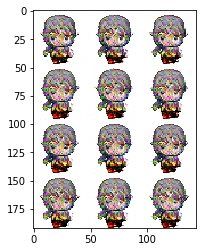

In [86]:
content_images = split_into_frames(plt.imread('88_23.png'))
style_image_file = '7004_105'
style_images = get_k_frames(plt.imread('{}.png'.format(style_image_file)), 2)
style_images = np.tile(style_images, (12,1,1,1,1))

generated = try_on_images(cpu_est, content_images, style_images)

images = [im for im in generated]
combined = back_into_shape(images)
plt.imshow(combined)
plt.imsave('combined_{}.png'.format(style_image_file), combined)

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

try:
    do_experiment()
except Exception as e:
    print (e)
    pass